
<font color='blue'> **12_________________________________________________________________________________________________________**  </font>

In [1]:
from modflow_devtools.misc import get_env;write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True) 
import os      ; import matplotlib.pyplot as plt      ; import numpy as np  ; import pickle   ; from pathlib import Path ; import pathlib as pl   ; import matplotlib as mpl

import flopy   ; from flopy.plot.styles import styles ; import pandas as pd                   ; ID = 'e15'      ; REF1='E:/15_REPOS/02_Beta-Me/data/MF6/12_ex-gwf-sfr-pindersauer'
_R=Path("./_R");_R.mkdir(exist_ok=True);T12=Path("./_R/T12");T12.mkdir(exist_ok=True);T12b=Path("./_R/T12/b");T12b.mkdir(exist_ok=True)    ; EX='E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'

In [2]:
delr = np.loadtxt(os.path.join(REF1 ,'delr.txt'),dtype=float)     ; delc = 609.61             ; strt =np.loadtxt(os.path.join(REF1 ,'initial_head.txt'),dtype=float)
H1  =  np.loadtxt(os.path.join(REF1 ,'initial_stage_a.txt'),dtype=float)                      ; H2 =np.loadtxt(os.path.join(REF1 ,'initial_stage_b.txt'),dtype=float) ;nlay=1;nrow=65;ncol=15
top =  np.repeat(np.linspace(8.675181e01, 4.773705e01, nrow).reshape(nrow, 1), ncol, axis=1)  ; botm = 0                                    # np.savetxt(T12b / "aa4.csv", H2, delimiter=",")

In [3]:
k11=0.003048  ; ss=0.0000001 ; sy=0.25 ; nreaches=65 ; SLOPE=0.001  ; ROUGH=0.03858 ; Q_base=509.7   ; Q_amp=141.58                                       ; Gamma=4894.3 ; fr=0.000349
nper=1 ; nstp=288 ; dt=300.0 ; TIMES=np.arange(0.0,86400.0+dt,dt)   ; tdis_ds=[(86400.0,nstp,1.0)]   ; SRF_J=7 ;top[:,SRF_J]=np.linspace(6.065575e01,2.164100e01,nrow) ;LEAK2=1.42e-04

OBS_L=24.0*delc  ;OBS_I=int(OBS_L/delc)      ;IN_F=Q_base+Q_amp*np.sin(2.0*np.pi*TIMES/18000.0)  ;TS = [(t, q) for t, q in zip(TIMES, IN_F)]
UPS_F=[0.0]+(nrow-1)*[1.0]   ;NC=[1]+(nrow-2)*[2]+[1]    ;SFR_S={0:[(0,"inflow","inflow")]}      ;SFR_C=([(0,-1)]+[(idx,idx-1,-(idx+1))for idx in range(1,nrow-1)]+[(nrow-1,(nrow-2))])

PAR               = {"e12A": {"lambda_val":(-4.779e-2,-0.3608),"LEAK":0.0}   ,"e12B":{"lambda_val":(-0.1785,-0.3409),"LEAK": 1.42e-04}}
PAR["e12A"]["stage"] = [(ifno, float(H1[ifno])) for ifno in range(nreaches)]                        
PAR["e12B"]["stage"] = [(ifno, float(H2[ifno])) for ifno in range(nreaches)]    ; HH=H1       # https://modflow6-examples.readthedocs.io/en/develop/_notebooks/ex-gwf-sfr-pindersauer.html

In [4]:
def build_models(ID, lambda_val, LEAK, stage):
    IC = f"{ID}.sfr.obs"    ; SFR_P = [(ifno ,0 ,ifno ,SRF_J ,delc,delr[SRF_J] ,SLOPE       ,top[ifno, SRF_J] ,1.0 ,LEAK    ,ROUGH ,NC[ifno] ,UPS_F[ifno],0,) for ifno in range(nreaches)]                                   
    SFR_O = {f"{IC}.csv":[("inflow-ext" ,"ext-inflow",(0,))  ,("inflow","inflow",(OBS_I,))  ,("outflow","outflow",(OBS_I,)) ,("stage","stage",(OBS_I,))    ,("depth","depth",(OBS_I))]}  # __05

    sim_ws = os.path.join(T12b, ID)

    sim = flopy.mf6.MFSimulation   (sim_name=ID, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis   (sim, nper=nper, perioddata=tdis_ds, time_units="seconds")        ; flopy.mf6.ModflowIms (sim)                     ; gwf = flopy.mf6.ModflowGwf (sim, modelname=ID)
    flopy.mf6.ModflowGwfdis (gwf,length_units="meters",nlay=nlay,nrow=nrow,ncol=ncol,delr=delr, delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwfnpf (gwf,icelltype=1,k=k11)                                           ; flopy.mf6.ModflowGwfsto(gwf, iconvert=1,sy=sy,ss=ss,transient={0: True})  
    flopy.mf6.ModflowGwfic  (gwf,strt=strt)                                                   ; flopy.mf6.ModflowGwfoc (gwf, printrecord=[("budget", "all")])
    sfr = flopy.mf6.ModflowGwfsfr (gwf,print_input=True,print_flows=True,nreaches=nreaches,packagedata=SFR_P,connectiondata=SFR_C,perioddata=SFR_S,pname="sfr-1")
    sfr.ts.initialize  (filename=f"{ID}.sfr.ts",timeseries=TS,time_series_namerecord=["inflow"],interpolation_methodrecord=["linearend"])
    sfr.obs.initialize (filename=IC,print_input=True,continuous=SFR_O)                        ; return sim

def write_models(sim, silent=True):   sim.write_simulation(silent=silent)
def run_models(sim, silent=True):     success, buff = sim.run_simulation(silent=silent)  ; assert success, buff
def scenario(idx, silent=True):
    key = list(PAR.keys())[idx]                    ; PAR2 = PAR[key].copy()       ; sim = build_models(key, **PAR2)
    if write: write_models (sim, silent=silent)   
    if run:   run_models   (sim, silent=silent)
scenario(0)  ; scenario(1)  # w/leakage. / # w/o leakage.

In [5]:
sim1 = flopy.mf6.MFSimulation.load(sim_ws = T12b/'e12A'    ,exe_name=EX,  verbosity_level=0)
obs1 = sim1.get_model().sfr.output.obs().get_data()           ;  obs1["totim"] /= 3600.0; pd.DataFrame(obs1) ; 
sim2 = flopy.mf6.MFSimulation.load(sim_ws = T12b/'e12B'    ,exe_name=EX,  verbosity_level=0)
obs2 = sim2.get_model().sfr.output.obs().get_data()           ;  obs2["totim"] /= 3600.0; pd.DataFrame(obs2) ; obs2; 
pd.DataFrame(os.listdir(T12b/'e12A')).to_csv(T12/"L12_LIST.csv")  

**no leakage / leakage _ MODFLOW _ Stage(m)**

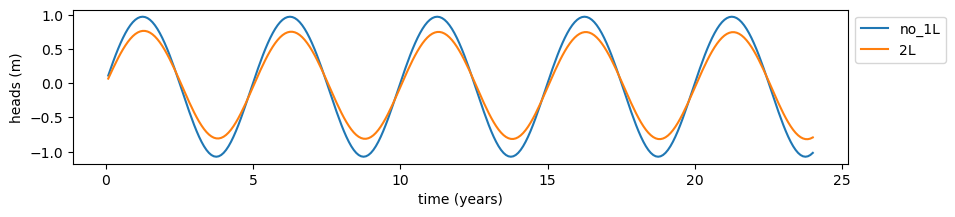

In [6]:
b1 = obs1["DEPTH"] ; bb1 = b1 - b1.mean()  ; df1 = pd.DataFrame(bb1,columns=['no_1L']) ; df0 = pd.DataFrame(obs1['totim'],columns=['totim']) 
b2 = obs2["DEPTH"] ; bb2 = b2 - b2.mean()  ; df2 = pd.DataFrame(bb2,columns=['2L'])    ; df3 = pd.concat([df0,df1, df2], axis = 1) ; df3; 
ax = df3.plot(x="totim", y= ['no_1L','2L'] , kind="line", figsize=(10,2))  
ax.legend(bbox_to_anchor=(1.0, 1.0)); ax.set(xlabel="time (years)", ylabel="heads (m)"); plt.show()

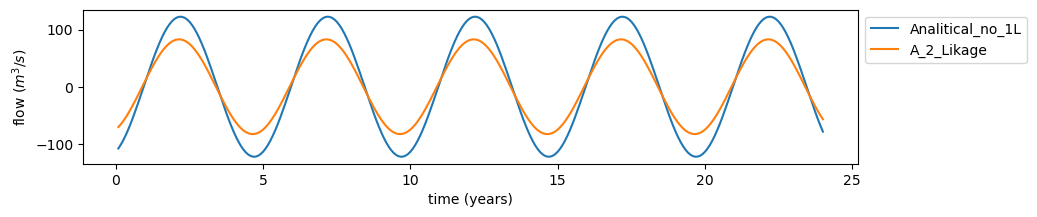

In [7]:
def analytical_solution(lambdas, x, t):    return Q_base + Q_amp * np.exp(lambdas[0] * x / Gamma) * np.sin(fr * t + lambdas[1] * x / Gamma)
list(PAR.values())                ; analytical = []
for key, value in PAR.items():      lambda_val = value["lambda_val"]      ; analytical.append(analytical_solution(lambda_val,OBS_L,TIMES)-Q_base)
df = pd.DataFrame(analytical).T          ; df.columns = ["Analitical_no_1L", "A_2_Likage"]           ; df.to_csv (T12/"aa5.csv")

df4 = pd.concat([df0,df], axis = 1)      ; df4.drop(df.tail(1).index,inplace=True) 
ax = df4.plot(x="totim", y= ["Analitical_no_1L", "A_2_Likage"]  , kind="line", figsize=(10,2))  
ax.legend(bbox_to_anchor=(1.0, 1.0)); ax.set(xlabel="time (years)", ylabel="flow ($m^3/s$)"); plt.show()